In [1]:
%matplotlib inline
from stack_nlp import *
from jupyter_mplsettings import *
matplotlib.rc('font', **font)

In [2]:
cfg = local_import("./default.py")

In [3]:
PrepareData(cfg)

Shape of question df (1696819, 21)
Shape of answer df (2028240, 21)
Loading word dictionary...
Warning! Dropping some words from word list, please verify!
Calculating normalized columns. They are available under usual column name + _norm.


In [4]:
data = cfg.data

In [5]:
data.keys()

['meta', 'dict', 'features', 'answers']

In [25]:
qs = data["meta"];

In [26]:
qs.head()
print qs.shape

(673622, 48)


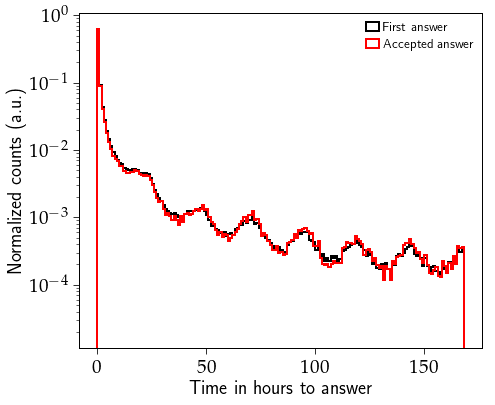

In [27]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time in hours to answer")
plt.ylabel(r"Normalized counts (a.u.)")
plt.hist(qs.dt_answer_hour, range=[0, 7 * 24], bins=7 * 24, 
         histtype="step", lw=2, color="k", label="First answer", normed=True, log=True);
plt.hist(qs.dt_accanswer_hour, range=[0, 7 * 24], bins=7 * 24,
        histtype="step", lw=2, color="r", label="Accepted answer", normed=True, log=True);
# plt.semilogy(nonposy="clip")
plt.legend(loc="upper right")
plt.savefig("./plots/dthist_first_accepted_normed.pdf")

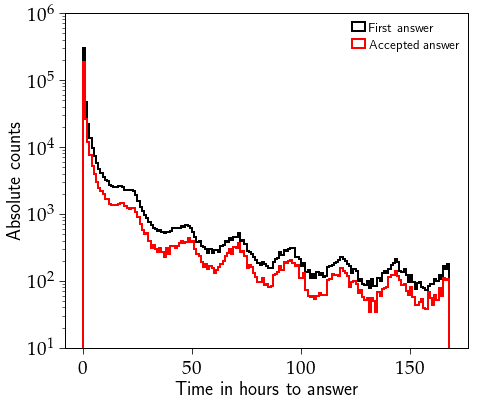

In [28]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time in hours to answer")
plt.ylabel(r"Absolute counts")
plt.hist(qs.dt_answer_hour, range=[0, 7 * 24], bins=7 * 24, 
         histtype="step", lw=2, color="k", label="First answer", log=True);
plt.hist(qs.dt_accanswer_hour, range=[0, 7 * 24], bins=7 * 24,
        histtype="step", lw=2, color="r", label="Accepted answer", log=True);
# plt.semilogy(nonposy="clip")
plt.ylim(10, 10 ** 6)
plt.legend(loc="upper right")
plt.savefig("./plots/dthist_first_accepted.pdf")

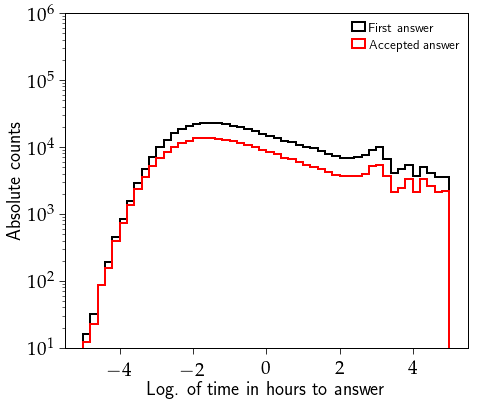

In [68]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Log. of time in hours to answer")
plt.ylabel(r"Absolute counts")
plt.hist(qs.dt_answer_hour.apply(np.log), bins=50, 
         histtype="step", lw=2, color="k", range=[-5, 5], label="First answer", log=True);
plt.hist(qs.dt_accanswer_hour.apply(np.log), bins=50,
        histtype="step", lw=2, color="r", range=[-5, 5], label="Accepted answer", log=True);
# plt.semilogy(nonposy="clip")
plt.ylim(10, 10 ** 6)
plt.legend(loc="upper right")
plt.savefig("./plots/dthist_log_first_accepted.pdf")

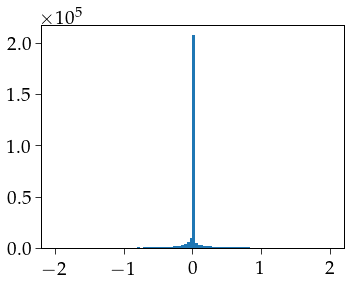

In [14]:
plt.hist(qs.dt_accanswer_hour - qs.dt_answer_hour, range=[-2, 2], bins=100);
# plt.semilogy(nonposy="clip")

In [32]:
print np.sum(~qs.dt_answer.isnull())
print np.sum(~qs.dt_accanswer.isnull())

536044
307514


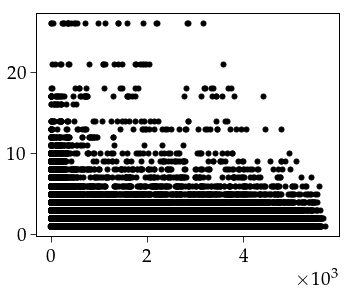

In [16]:
plt.plot(qs.dt_answer_hour, qs.AnswerCount, "k.")

In [11]:
qs.columns

Index([u'AcceptedAnswerId', u'AnswerCount', u'BodyNCodes', u'BodyNQMarks',
       u'BodySize', u'ClosedDate', u'CommentCount', u'CommunityOwnedDate',
       u'CreationDate', u'FavoriteCount', u'Id', u'LastActivityDate',
       u'LastEditDate', u'LastEditorUserId', u'OwnerUserId', u'ParentId',
       u'PostTypeId', u'Score', u'Tags', u'Title', u'ViewCount', u'titlelen',
       u'hasAnswers', u'dt_created', u'Id_r', u'hot_indices', u'nwords',
       u'ordersum', u'prob_bern', u'prob_poiss', u'ratio', u'ParentId_first',
       u'CreationDate_first', u'Id_acc', u'CreationDate_acc', u'dayhour',
       u'weekday', u'dt_answer', u'dt_accanswer', u'dt_answer_hour',
       u'dt_accanswer_hour', u'BodyNCodes_norm', u'BodyNQMarks_norm',
       u'BodySize_norm', u'titlelen_norm', u'nwords_norm', u'ordersum_norm',
       u'ratio_norm'],
      dtype='object')

[ 1.  4.]


stack_util.py:252: RuntimeWarning: divide by zero encountered in log10
  max(2 - np.floor(np.abs(np.log10(ztrafo(zedgs[i])))), 0), 2)


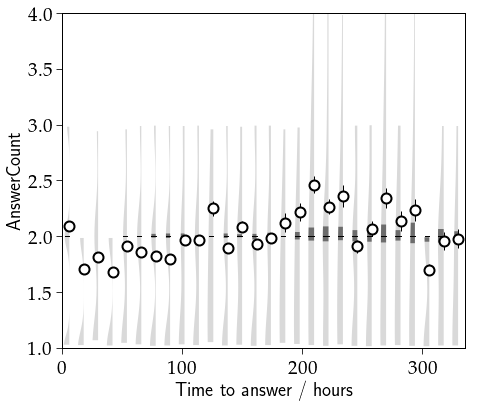

[ 0.  7.]


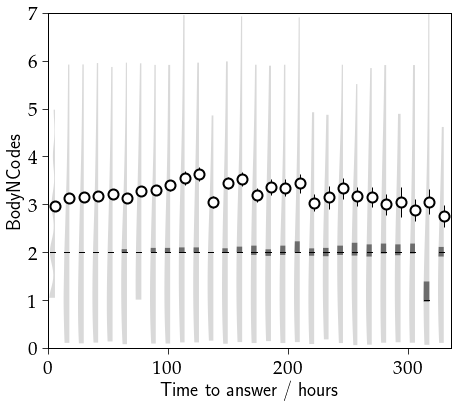

[ 0.  3.]


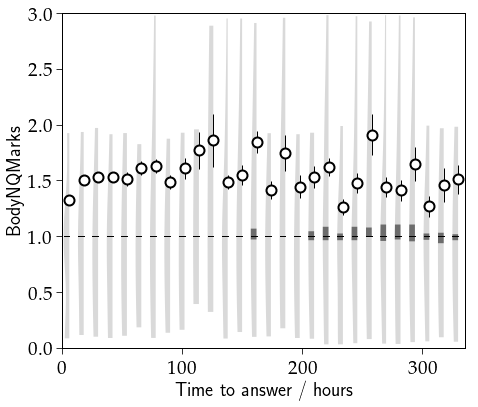

[  396.  3127.]


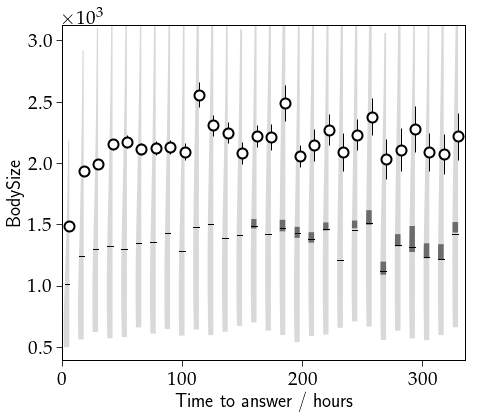

[ 31.  80.]


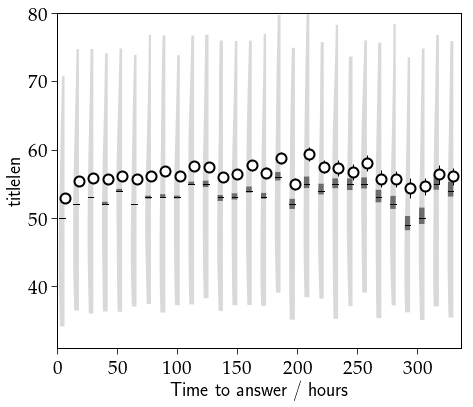

[ 14.  74.]


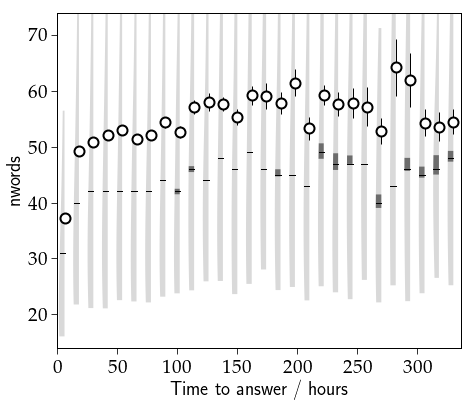

[  2974.  23345.]


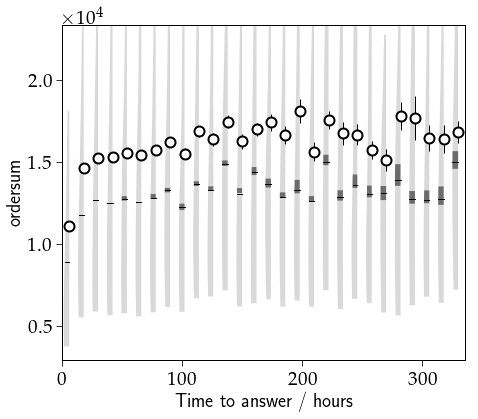

[ 0.26086957  0.88235294]


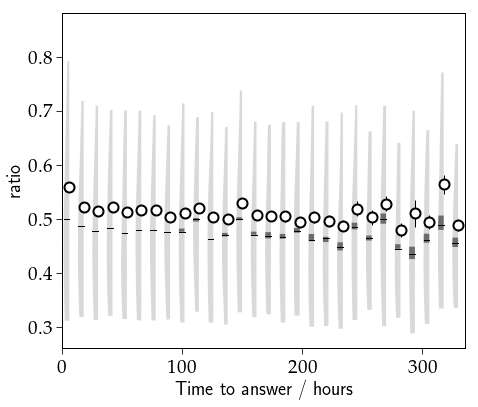

[ 0.  2.]


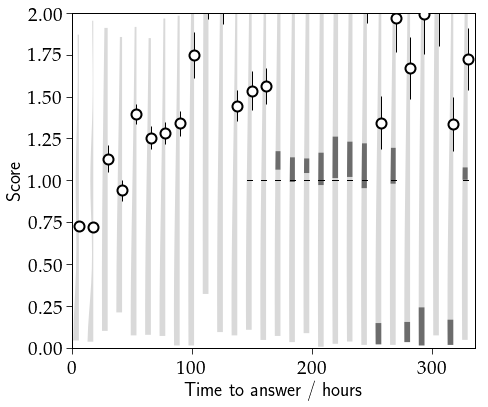

[  2.23909674e-54   3.09808260e-18]


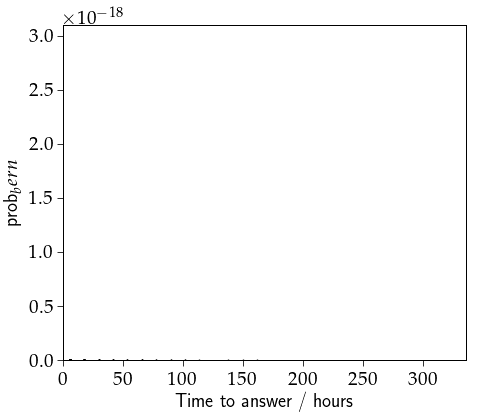

In [12]:
qs.columns
m = np.isfinite(qs.dt_accanswer_hour)

ndays = 14
# dthours = qs.dt_answer.dt.total_seconds() * 1. / 3600
cols = ["AnswerCount", "BodyNCodes", "BodyNQMarks", "BodySize", "titlelen", "nwords", "ordersum", "ratio", "Score", "prob_bern"]
# f, axarr = plt.subplots(2, 4, squeeze=False)
for i, col in enumerate(cols):
    quants = mquantiles(qs[m][col], prob=[0.1, 0.9])
    print quants
    plt.figure(i, figsize=(8, 6))
    plt.xlabel(r"Time to answer / hours")
    plt.ylabel(r"%s" % col)
#     plt.plot(dthours, qs[col], "k.")
    QuickSlicePlot(qs.dt_accanswer_hour[m], qs[m][col], qs.dt_accanswer_hour[m], zbins=1, yrange=quants, 
                   xRange=[0, ndays * 24], xbins=2 * ndays, draw="amvs",
                   axes=plt.gca())
    plt.xlim(0, ndays * 24)
    plt.show()
    plt.savefig("./plots/%s_vs_answertime.pdf" % col)
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
# plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
# plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

In [33]:
qs["dayhour"] = qs.CreationDate.dt.hour
qs["weekday"] = qs.CreationDate.dt.dayofweek
# training and testing samples
qs = shuffle(qs)
print len(qs)
# limiting to questions with accepted answer for training
qsgood = qs[~qs.dt_accanswer.isnull()]
# for training, consider only first weeks for answer time (due to reweighting)
qsgood = qsgood[qsgood.dt_accanswer_hour <= 14 * 24]
qsgood = qsgood[qsgood.dt_accanswer_hour > 0]
print len(qsgood)
train = 200000
qstrain = qsgood.iloc[:train]
qstest = qsgood.iloc[train:]
print len(qstrain)
print len(qstest)

label = "dt_accanswer_hour"

# sample with no answers, aka the ultimate testing sample
qsnone = qs[qs.AnswerCount == 0]
print len(qsnone)

673622
297772
200000
97772
137566


In [51]:
# we probably want to reweight events according to the steeply falling time distribution...
#max(qstrain.dt_accanswer_hour)
# counts, edges = np.histogram(qstrain.dt_accanswer_hour, mquantiles(qstrain.dt_accanswer_hour, prob=np.linspace(0., 1., 100)))
from pyik.numpyext import centers

counts, edges = np.histogram(np.log(qstrain.dt_accanswer_hour), bins=300)
cens = centers(edges)[0]
counts = counts * 1. / np.sum(counts)
counts;
print edges[:10];
weights = 1. / counts[np.minimum(np.digitize(np.log(qstrain.dt_accanswer_hour.values), edges) - 1, len(counts) - 1)]
print qstrain.dt_accanswer_hour.iloc[:10]
qstrain["weights"] = weights
print qstrain.weights.iloc[:10]

[-5.56855253 -5.53060045 -5.49264837 -5.4546963  -5.41674422 -5.37879214
 -5.34084007 -5.30288799 -5.26493592 -5.22698384]
593368     5.109792
537263    30.851640
336118     0.178728
474740     0.414312
133905     0.091080
487964     0.058632
342287     2.183376
143274     1.432608
159726     1.060512
666346     2.715840
Name: dt_accanswer_hour, dtype: float64
593368    379.506641
537263    740.740741
336118    116.279070
474740    127.959053
133905    141.643059
487964    215.982721
342287    248.447205
143274    205.761317
159726    172.117040
666346    294.550810
Name: weights, dtype: float64


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [16]:
qstrain.columns

Index([u'AcceptedAnswerId', u'AnswerCount', u'BodyNCodes', u'BodyNQMarks',
       u'BodySize', u'ClosedDate', u'CommentCount', u'CommunityOwnedDate',
       u'CreationDate', u'FavoriteCount', u'Id', u'LastActivityDate',
       u'LastEditDate', u'LastEditorUserId', u'OwnerUserId', u'ParentId',
       u'PostTypeId', u'Score', u'Tags', u'Title', u'ViewCount', u'titlelen',
       u'hasAnswers', u'dt_created', u'Id_r', u'hot_indices', u'nwords',
       u'ordersum', u'prob_bern', u'prob_poiss', u'ratio', u'ParentId_first',
       u'CreationDate_first', u'Id_acc', u'CreationDate_acc', u'dayhour',
       u'weekday', u'dt_answer', u'dt_accanswer', u'dt_answer_hour',
       u'dt_accanswer_hour', u'BodyNCodes_norm', u'BodyNQMarks_norm',
       u'BodySize_norm', u'titlelen_norm', u'nwords_norm', u'ordersum_norm',
       u'ratio_norm', u'weights'],
      dtype='object')

In [17]:
import dill
# dill.dump(estimator, open('estimator.dill', 'w'))
# estimator = dill.load(open('estimator.dill', 'r'))

## Fitting random forest to the space of simple features derived from the text

In [35]:
cols = [col for col in qstrain.columns if "_norm" in col]
print cols

['BodyNCodes_norm', 'BodyNQMarks_norm', 'BodySize_norm', 'titlelen_norm', 'nwords_norm', 'ordersum_norm', 'ratio_norm']


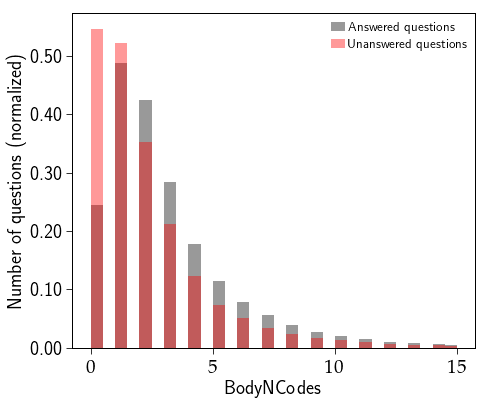

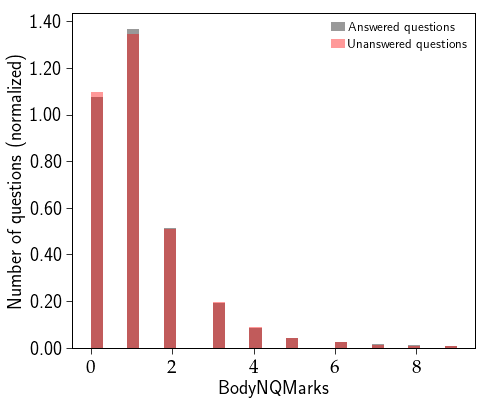

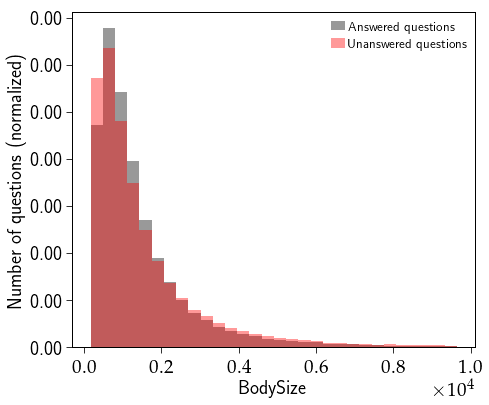

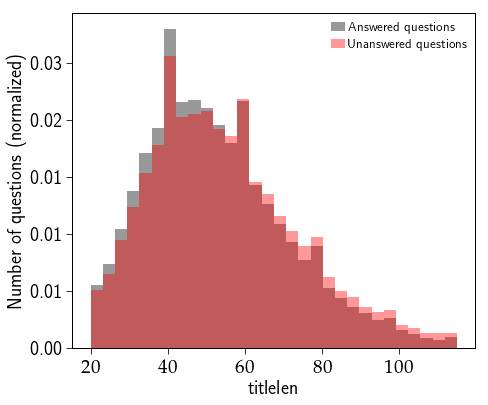

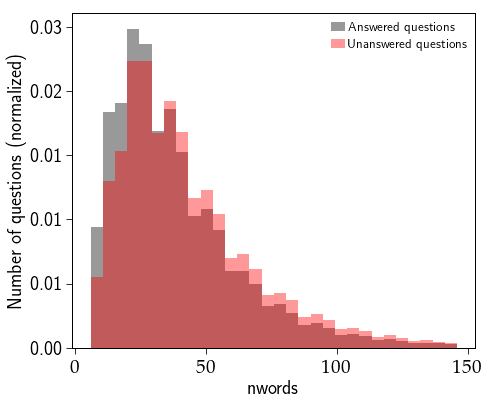

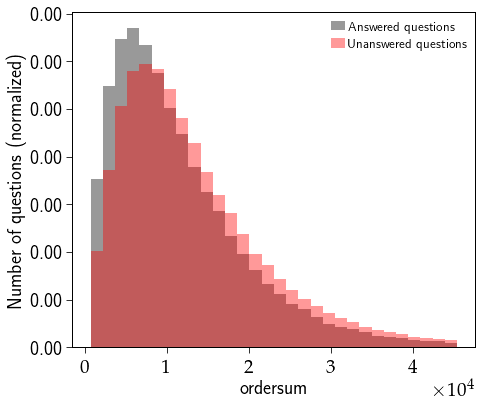

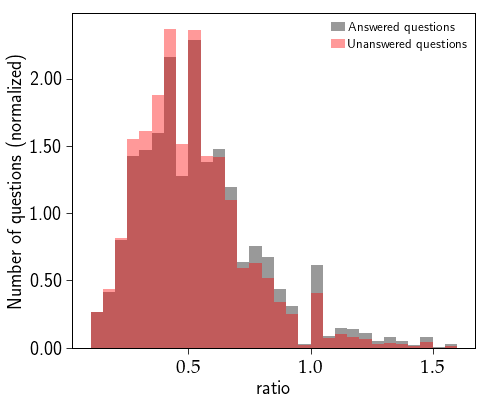

In [71]:
for col in cols:
    cvals = qstrain[col]
    quants = mquantiles(cvals, prob=np.linspace(0.01, 0.99, 30))
    plt.figure(figsize=(8, 6))
    plt.ylabel(r"Number of questions (normalized)")
    plt.xlabel(col.replace("_norm", ""))
    plt.hist(qstrain[col], range=[min(quants), max(quants)], bins=30, 
             color="k", histtype="stepfilled", alpha=0.4, lw=2, 
             label="Answered questions", density=True)
    plt.hist(qsnone[col], range=[min(quants), max(quants)], bins=30, 
             color="r", histtype="stepfilled", alpha=0.4, lw=2, 
             label="Unanswered questions", density=True)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    plt.legend(loc="best")
    plt.savefig("./plots/histcomp_%s.pdf" % col.replace("_norm", ""))

In [84]:
pipe_feat_fct = lambda a: Pipeline([
         ("cst", ColumnSelectTransformer([col for col in qstrain.columns if "_norm" in col] + ["weekday", "dayhour"])),
         ("poly", PolynomialFeatures(degree=2)),
#          ("ridge", Ridge(alpha=a, normalize=True))
         ("multi", MultiModelRegressor(Ridge(alpha=a, normalize=True), RandomForestRegressor(n_estimators=20)))
#          ("ranforest", RandomForestRegressor(n_estimators=15))
    ])

pipe_feat = pipe_feat_fct(2)

In [ ]:
cv = model_selection.ShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
def compute_error(est, X, y):
    return -model_selection.cross_val_score(est, X, y, cv=cv, scoring='neg_mean_squared_error').mean()

for alpha in np.linspace(0.1, 10, 20):
    pipe = pipe_feat_fct(alpha)
    pipe.fit(qstrain, np.log(qstrain[label]))
    print alpha, compute_error(pipe, qstrain, np.log(qstrain[label]))

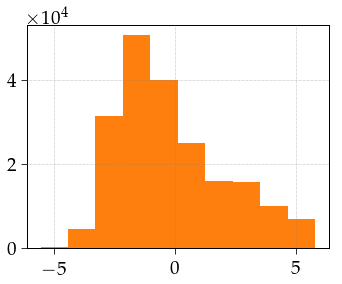

In [67]:
np.log(qstrain[label]).hist()
qstrain.dt_accanswer_hour.apply(np.log).hist()
# qs.dt_accanswer_hour.apply(np.log).hist()

In [60]:
# weighted ridge regression
# pipe_feat.fit(qstrain, np.log(qstrain[label]), **{"multi__sample_weight": qstrain.weights})
# unweighted
pipe_feat.fit(qstrain, np.log(qstrain[label]))
pred = pipe_feat.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
print pipe_feat.score(qstest, np.log(qstest[label]))
# print pipe_feat.score(qstest, np.log(qstest[label]), sample_weight=qstest.weights)

Performing base regression...
Performing residual regression...
[[-0.17332528 -1.24080278]
 [ 2.30415022  2.53918837]
 [-0.76903164 -2.46557472]
 ..., 
 [-0.13071229 -2.54889492]
 [ 0.19299802 -1.11581542]
 [ 1.13742995  3.57332448]]
0.409829850475


In [83]:
pipe_tags = Pipeline([
                     ("cst", ColumnSelectTransformer(["Tags"])),
                     ("dec", DictEncoder("Tags")),
                     ("dvec", DictVectorizer(sparse=True)),
                     ("tfid", TfidfTransformer()),
                     # ("poly", PolynomialFeatures(degree=2)),  # not working???
#                      ("ridge", Ridge(alpha=2.0))
                     ("multi", MultiModelRegressor(Ridge(alpha=2, normalize=True), RandomForestRegressor(n_estimators=15)))
                     # ("kridge", KernelRidge(alpha=1.))  # runs out of memory quickly while fitting...
                     # ("svr", SVR())
                     ])

In [75]:
pipe_tags.fit(qstrain, np.log(qstrain[label]))
pred = pipe_tags.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
print pipe_tags.score(qstest, np.log(qstest[label]))

Performing base regression...
Performing residual regression...
[[-1.61607522 -1.24080278]
 [ 2.53918837  2.53918837]
 [-1.70819642 -2.46557472]
 ..., 
 [-1.40425083 -2.54889492]
 [-1.76401012 -1.11581542]
 [ 3.78464234  3.57332448]]
0.204984000645


In [85]:
pipe_words = Pipeline([
                      ("cst", ColumnSelectTransformer(["hot_indices"])),
                      ("dec", DictEncoder("hot_indices")),
                      ("dvec", DictVectorizer(sparse=True)),
                      ("tfid", TfidfTransformer()),
#                       ("ridge", Ridge(alpha=2.0))
#                       ("multi", MultiModelRegressor(Ridge(alpha=a, normalize=True), RandomForestRegressor(n_estimators=15)))
#                       ("multi", MultiModelRegressor(Ridge(alpha=2, normalize=True), MLPRegressor(hidden_layer_sizes=(50, 50))))
                      ("mlp", MLPRegressor(hidden_layer_sizes=(100, 100)))
                      ])

In [80]:
pipe_words.fit(qstrain, np.log(qstrain[label]))
pred = pipe_words.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
print pipe_words.score(qstest, np.log(qstest[label]))

Performing base regression...
Performing residual regression...
[[-1.03373817 -1.24080278]
 [-0.74439165  2.53918837]
 [-0.94221948 -2.46557472]
 ..., 
 [-1.19651104 -2.54889492]
 [-0.30994891 -1.11581542]
 [-0.43371871  3.57332448]]
-0.0198264076902


In [90]:
from sklearn.pipeline import FeatureUnion
union = FeatureUnion([
                     ("tags", EstimatorTransformer(pipe_tags)),
                     ("words", EstimatorTransformer(pipe_words)),
                     ("feat", EstimatorTransformer(pipe_feat))
                     ])

pipe_combined = Pipeline([
                    ("union", union),
                    ("ridge", Ridge(alpha=3.0))
                    # ("comb", CustomCombiner())
                    ])

In [ ]:
pipe_combined.fit(qstrain, np.log(qstrain[label]))
pred = pipe_combined.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
print pipe_combined.score(qstest, np.log(qstest[label]))

Performing base regression...
Performing residual regression...


In [47]:
import dill

In [104]:
dill.dump(pipe_feat, open("pipe_feat.dill", "w"))

In [ ]:
pipe_feat = dill.load(open('pipe_feat.dill', 'r'))

## Investigating difference (residuals) in test sample vs. various dimensions

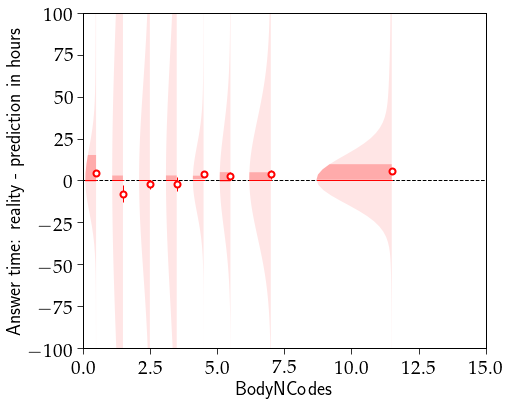

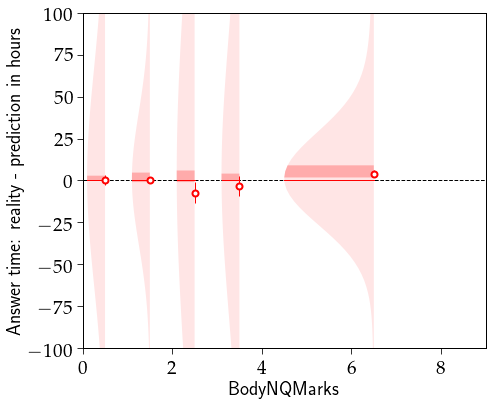

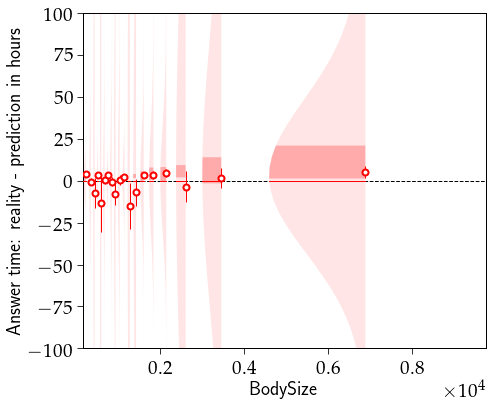

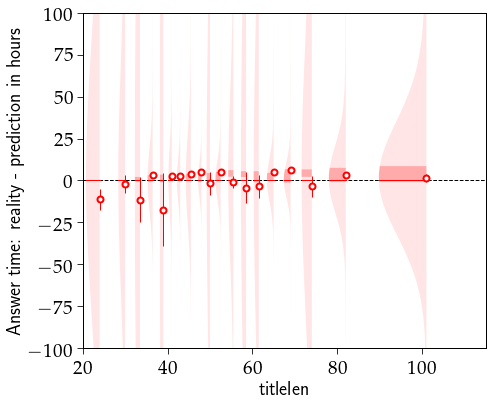

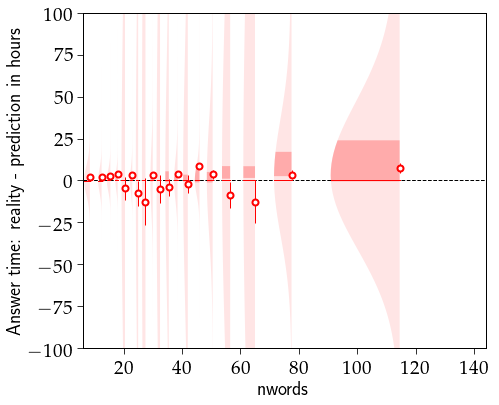

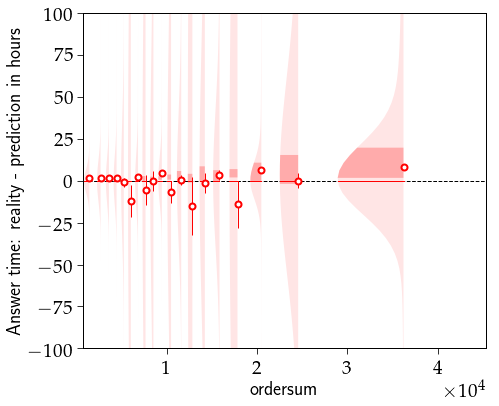

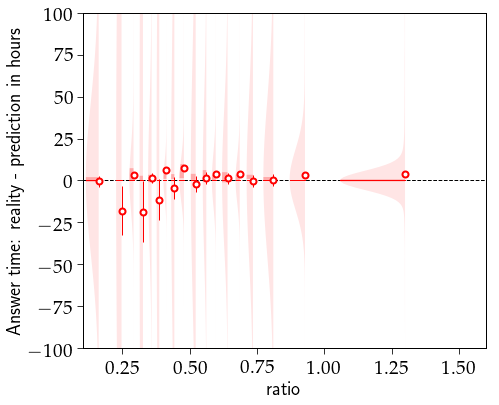

In [76]:
predtimes = np.e ** pred
cols = [col.replace("_norm", "") for col in qstrain.columns if "_norm" in col]
diff = qstest[label] - predtimes

for i, col in enumerate(cols):
    yquants = mquantiles(diff, prob=[0.05, 0.95])
    xquants = mquantiles(qstest[col], prob=np.linspace(0.01, 0.99, 20))
    plt.figure(i, figsize=(8, 6))
    plt.xlabel("%s" % col)
    plt.ylabel(r"Answer time: reality - prediction in hours")
    QuickSlicePlot(qstest[col], diff, qstest.dt_accanswer_hour, zbins=1, yrange=yquants, 
                   xbins=xquants, draw="amv", color="red", ms=6,
                   axes=plt.gca())
    plt.axhline(0, lw=1, ls="--", color="k")
    plt.ylim(-100, 100)
    plt.xlim(min(xquants), max(xquants))
    plt.savefig("./plots/residual_vs_%s.pdf" % col)

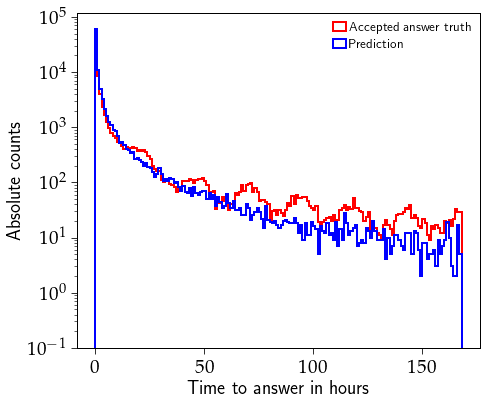

In [77]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time to answer in hours")
plt.ylabel(r"Absolute counts")
plt.hist(qstest.dt_answer_hour, range=[0, 7 * 24], bins=7 * 24, 
         histtype="step", lw=2, color="r", label="Accepted answer truth", log=True);
plt.hist(predtimes, range=[0, 7 * 24], bins=7 * 24,
        histtype="step", ls="-", lw=2, color="b", label="Prediction", log=True);
# plt.semilogy(nonposy="clip")
plt.legend(loc="upper right")
plt.savefig("./plots/dthist_predictions.pdf")

In [ ]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time to answer in hours")
plt.ylabel(r"Absolute counts")
plt.hist(qstest.apply(np.log).dt_answer_hour, range=[-5, 5], bins=30, 
         histtype="step", lw=2, color="r", label="Accepted answer truth", log=True);
plt.hist(predtimes.apply(np.log), range=[-5, 5], bins=30,
        histtype="step", ls="-", lw=2, color="b", label="Prediction", log=True);
# plt.semilogy(nonposy="clip")
plt.legend(loc="upper right")
plt.savefig("./plots/dthist_log_predictions.pdf")

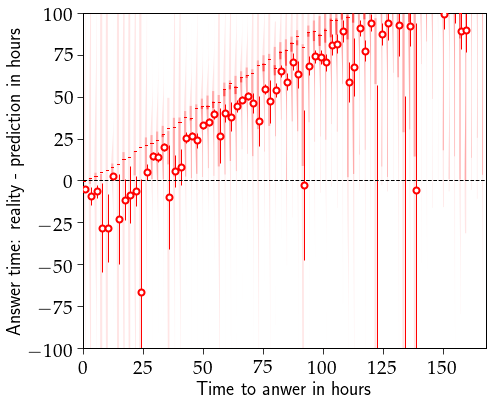

In [78]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time to anwer in hours")
plt.ylabel(r"Answer time: reality - prediction in hours")
QuickSlicePlot(qstest.dt_answer_hour, diff, qstest.dt_accanswer_hour, zbins=1, yrange=[-50, 50], 
               xRange=[0, 7 * 24], xbins=3 * 24, draw="amv", color="red", ms=6,
               axes=plt.gca())
plt.axhline(0, lw=1, ls="--", color="k")
plt.ylim(-100, 100)
plt.xlim(0, 7 * 24)
plt.savefig("./plots/dtresidual_vs_dt.pdf")

## effect of the number of questions per time (more questions -> more answer delay?)

In [58]:
# number of 
date_edges = pd.date_range(qstrain.CreationDate.min(), qstrain.CreationDate.max(), freq="H")
# print date_edges
date_centers = date_edges[:-1] + (date_edges[1:] - date_edges[:-1]) / 2
date_centers = date_centers.to_pydatetime()
# print date_centers
allcounts = pd.cut(qstrain.CreationDate, bins=date_edges).value_counts().values[::-1]

In [62]:
allcounts.shape
date_edges.shape

(1716,)

In [ ]:
qstrain

In [88]:
print qstrain.shape
# doing it with groupby...more elegant
qrate = qstrain.groupby([qstrain.CreationDate.dt.year, qstrain.CreationDate.dt.month, 
                         qstrain.CreationDate.dt.day, qstrain.CreationDate.dt.hour]).size()

(200000, 46)


In [90]:
qstrainmulti = qstrain.set_index([qstrain.CreationDate.dt.year, qstrain.CreationDate.dt.month, 
                                  qstrain.CreationDate.dt.day, qstrain.CreationDate.dt.hour])
qstrainmulti["qrate"] = qrate
qstrain = qstrainmulti.reset_index(drop=True)
print qstrain.shape

(200000, 47)


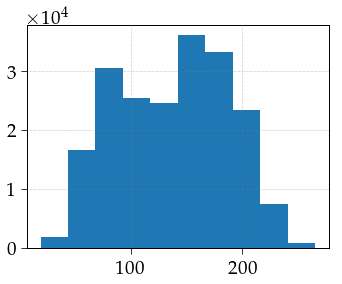

In [96]:
qstrain.qrate.hist()

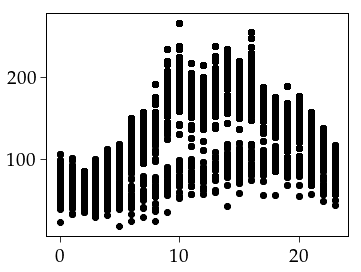

In [98]:
plt.plot(qstrain.CreationDate.dt.hour, qstrain.qrate, "k.")

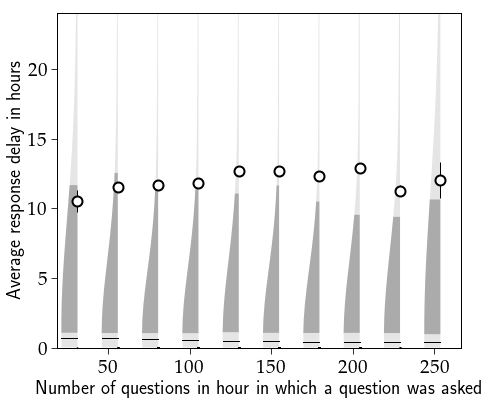

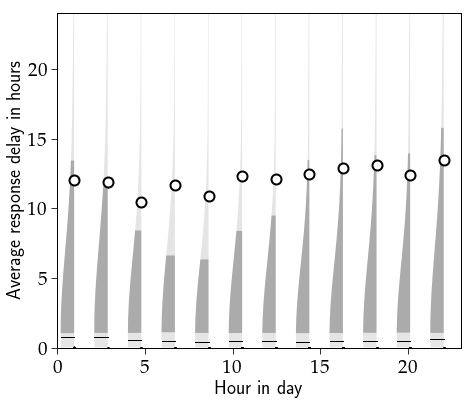

In [99]:
# dependence of average answer delay with the rate of questions in the same hour of asking a particular question
plt.figure(figsize=(8, 6))
plt.xlabel("Number of questions in hour in which a question was asked")
plt.ylabel("Average response delay in hours")
QuickSlicePlot(qstrain.qrate, qstrain.dt_accanswer_hour, qstrain.Score, zbins=1, xbins=10,
              yrange=[0, 24], draw="amv", axes=plt.gca())
plt.show()

# dependence of average answer delay with the rate of questions in the same hour of asking a particular question
plt.figure(figsize=(8, 6))
plt.xlabel("Hour in day")
plt.ylabel("Average response delay in hours")
QuickSlicePlot(qstrain.CreationDate.dt.hour, qstrain.dt_accanswer_hour, qstrain.Score, zbins=1, xbins=12,
              yrange=[0, 24], draw="amv", axes=plt.gca())
plt.show()